# Data analysis

In this lesson we treat Spatial Data Analysis, often called [Spatial Analysis](https://en.wikipedia.org/wiki/Spatial_analysis)
or even Spatial Statistics. 

> Spatial analysis or spatial statistics includes any of the formal techniques which 
> study entities using their topological, geometric, or geographic properties. From [Wikipedia](https://en.wikipedia.org/wiki/Spatial_analysis). 

Wikipedia actually provides [a nice overview](https://en.wikipedia.org/wiki/Spatial_analysis) to give you a feel what Spatial Analysis is about.


## Analysis with Fiona and Shapely
Let's explore some of Shapely's functions for *(Topological) Spatial Relationships*.
See simplified view below, more [on Wikipedia](https://en.wikipedia.org/wiki/Spatial_relation).

![(Topological) Spatial Relationships](images/spatialrelations.png)
*Examples of topological spatial relations - [By Krauss - Own work, CC BY-SA 3.0](https://commons.wikimedia.org/w/index.php?curid=21299138)*
 
If you want to dive into
a theoretical background, check out the [Dimensionally Extended nine-Intersection Model (DE-9IM)](https://en.wikipedia.org/wiki/DE-9IM). 

We'll start simple, answering the question: **Does the Donau float through Romenia?**. We'll use two National Earth datasets: Rivers and lakes
(LineStrings) and (Admin-0) Countries. In spatial 
relationship-terms: *Is the (Multi)LineString representing the Donau crossing the (Multi)Polygon representing Romenia?"* 

We will follow these steps:

* read the Rivers and Lakes dataset
* extract the Donau feature Geometry  
* read the Countries dataset
* extract the Romania feature Geometry  
* apply the Shapely `crosses` function
* advanced: list all DE-9IM relations of the two geometries
* advanced: through which countries does the Donau float?


In [11]:
import fiona
from shapely.geometry import shape


### Fetch the Donau geometry.


In [12]:
with fiona.open("../data/rivers_lake_centerlines.gpkg") as rivers_lakes:
	for feature in rivers_lakes:
		if feature['properties']['name'] == 'Donau':
			donau_geom = shape(feature["geometry"])
			print('Found Donau! geom type: %s' % donau_geom.type)
			break
donau_geom.type

Found Donau! geom type: LineString


'LineString'

### Fetch the Romania geometry.


In [13]:
with fiona.open("../data/countries.json") as countries:
	for feature in countries:
		if feature["properties"]["NAME"] == "Romania":
			romania_geom = shape(feature["geometry"])
			print('Found Romania! geom type: {}'.format(romania_geom.type))
			break


Found Romania! geom type: MultiPolygon


### Does the Donau float through Romania?


In [14]:
donau_geom.crosses(romania_geom)


True

### List the (DE-9IM) relationships.


In [15]:
donau_geom.relate(romania_geom)


'111FF0212'

### Through which countries does the Donau float?


In [16]:
print("The Donau floats through:")

with fiona.open("../data/countries.gpkg") as countries:
	for feature in countries:
		country_geom = shape(feature["geometry"])
		if donau_geom.crosses(country_geom):
			print(feature["properties"]["NAME"])
  

The Donau floats through:
Ukraine
Austria
Hungary
Romania
Germany
Bulgaria
Croatia
Slovakia
Serbia


# Analyzing atmospheric total ozone data

The [World Ozone and Ultraviolet Radiation Data Centre (WOUDC)](https://woudc.org) is one of six World Data Centres which are part of the Global Atmosphere Watch programme of the World Meteorological Organization. WOUDC provides an archive of daily total atmospheric ozone in a given column from the surface to the edge of the atmosphere.  Data is collected from a global network of monitoring stations across the world.

Total ozone is measured in [Dobson units](https://en.wikipedia.org/wiki/Dobson_unit) with an acceptable range of 100 - 700 du.

Let's generate a time series plot based on downloading GeoJSON data (via [WFS](https://geo.woudc.org/ows?service=WFS&version=1.1.0&request=GetFeature&outputformat=GeoJSON&typename=totalozone&filter=%3Cogc:Filter%3E%3Cogc:And%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Eplatform_id%3C/PropertyName%3E%3CLiteral%3E226%3C/Literal%3E%3C/PropertyIsEqualTo%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Eplatform_type%3C/PropertyName%3E%3CLiteral%3ESTN%3C/Literal%3E%3C/PropertyIsEqualTo%3E%3Cogc:PropertyIsBetween%3E%3Cogc:PropertyName%3Einstance_datetime%3C/ogc:PropertyName%3E%3Cogc:LowerBoundary%3E1924-01-01%2000:00:00%3C/ogc:LowerBoundary%3E%3Cogc:UpperBoundary%3E2019-12-31%2023:59:59%3C/ogc:UpperBoundary%3E%3C/ogc:PropertyIsBetween%3E%3C/ogc:And%3E%3C/ogc:Filter%3E&sortby=instance_datetime%20DESC&startindex=0&maxfeatures=200000)) of the [RNIMH Bucharest station 226](https://woudc.org/data/stations/?id=226&lang=en) record of the data and do some basic range checking.

333.49461909808093

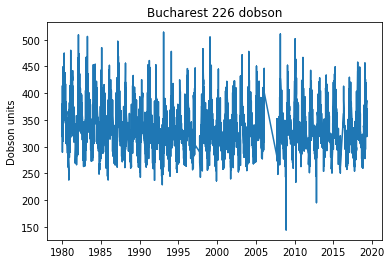

In [16]:
from datetime import datetime
import json
import gzip

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

with gzip.open('../data/totalozone-station-226.json.gz') as gzfh:
        data = json.load(gzfh)
        
len(data['features'])
# setup graph axes
x_axis = [datetime.strptime(x['properties']['instance_datetime'], '%Y/%m/%d 00:00:00+00') for x in data['features']]
y_axis = [float(x['properties']['daily_columno3']) for x in data['features']]

# render simple plot
plt.title('Bucharest 226 dobson')
plt.ylabel('Dobson units')
plt.plot(x_axis, y_axis)

# average
total_average = sum(y_axis) / float(len(y_axis))
total_average

Let's test whether any values fall outside the acceptable range:

In [194]:
max(y_axis) > 700 or min(y_axis) < 100

False

Now let's try importing all [WOUDC stations](https://woudc.org/data/stations/) into [GeoPandas](http://geopandas.org) and do some further analysis:

In [17]:
import geopandas

d = geopandas.read_file('../data/woudc-stations.geojson')

d.groupby('wmo_region').wmo_region.count()

wmo_region
I                 27
II                56
III               36
IV               153
V                 32
VI               186
the Antarctic     34
Name: wmo_region, dtype: int64

Let's plot only region VI stations (i.e. Europe)

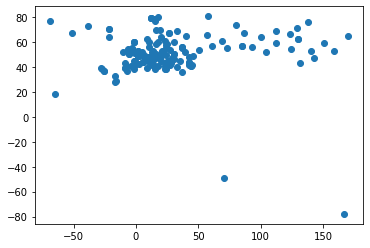

In [18]:
d[d.wmo_region.isin(['VI']) == True].plot()
# TODO: add basemap

---
[<- Raster Data](05-raster-data.ipynb) | [Visualization ->](07-visualization.ipynb)
